In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import shap
import joblib
import tensorflow as tf

# 1. SHAP analysis

In [3]:
# Import training and testing sets
X_train = pd.read_csv("/home/s2106664/msc_project/training_testing_dataset/X_train.csv")
X_validate = pd.read_csv("/home/s2106664/msc_project/training_testing_dataset/X_validate.csv")
X_test = pd.read_csv("/home/s2106664/msc_project/training_testing_dataset/X_test.csv")
y_train = pd.read_csv("/home/s2106664/msc_project/training_testing_dataset/y_train.csv").squeeze()
y_validate = pd.read_csv("/home/s2106664/msc_project/training_testing_dataset/y_validate.csv").squeeze()
y_test = pd.read_csv("/home/s2106664/msc_project/training_testing_dataset/y_test.csv").squeeze()

In [4]:
# Load scaler
scaler = joblib.load("/home/s2106664/msc_project/model_training/scaler.pkl")

# Features to scale (same as training)
scaled_features = ["hypermutation_rate", "cdr3_length", "Factor_I", "Factor_II",
                   "Factor_III", "Factor_IV", "Factor_V", "np1_length", "np2_length"]

X_test_scaled = X_test.copy()
X_test_scaled[scaled_features] = scaler.transform(X_test_scaled[scaled_features])

# Convert to tensor
X_test_tensor = torch.tensor(X_test_scaled.values, dtype=torch.float32)

class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(512, 512),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(512, 256),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(256, 512),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(512, 1)
        )

    def forward(self, x):
        return self.net(x)

# Load model
input_dim = X_test_tensor.shape[1]
model = MLP(input_dim=input_dim)
model.load_state_dict(torch.load("/home/s2106664/msc_project/model_training/best_mlp_sigmoid_model.pth"))
model.eval()

MLP(
  (net): Sequential(
    (0): Linear(in_features=78, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=256, out_features=512, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in_features=512, out_features=1, bias=True)
  )
)

In [5]:
X_test_tensor.shape

torch.Size([911341, 78])

In [51]:
torch.manual_seed(42)

# Suppose X is your tensor of shape (N, d)
N = X_test_tensor.size(0)

# Generate a random permutation of indices [0, 1, …, N-1]
perm = torch.randperm(N)

# Take the first 500 indices from the shuffled order
selected_idx = perm[:15000]

# Index into X to get your random subset
X_sample = X_test_tensor[selected_idx]

SHAP values shape: (15000, 78)


/tmp/ipykernel_4003799/2540592816.py:28: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, test_samples.numpy(), feature_names=X_test_scaled.columns)


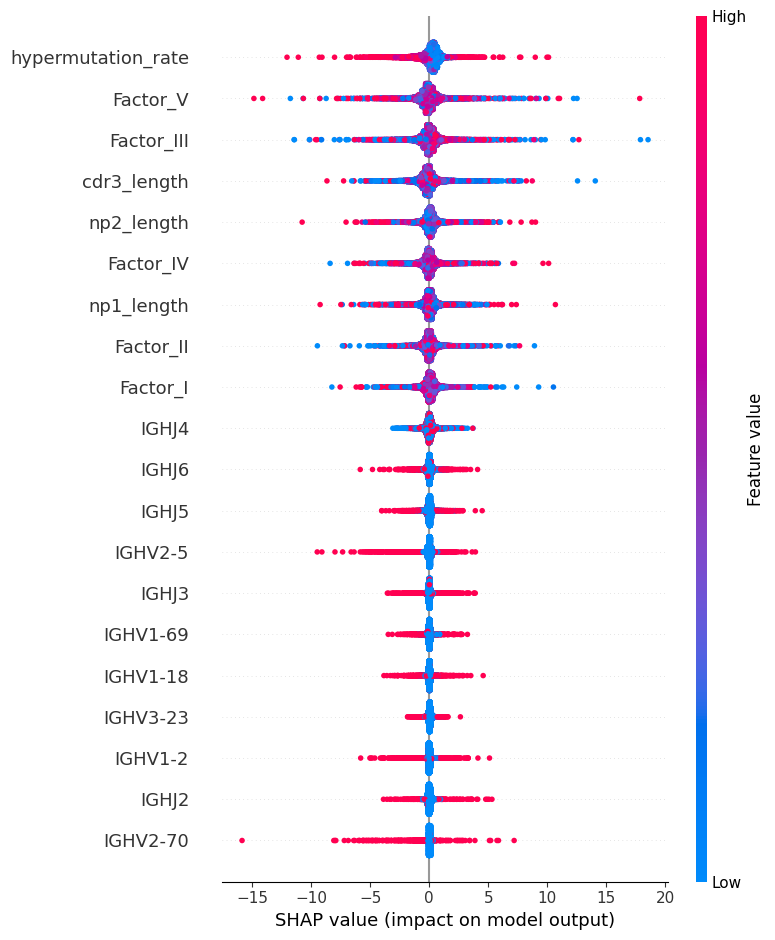

In [52]:
def model_wrapper(x_numpy):
    x_tensor = torch.from_numpy(x_numpy.astype(np.float32)).to(device)
    with torch.no_grad():
        logits = model(x_tensor)
        probs = torch.sigmoid(logits)  # Convert logits to probabilities
    return probs.cpu().numpy()

model.eval()
model.cpu()

# Use first 100 samples as background
background = X_test_tensor[:150].cpu()

# Select 50 samples to explain
test_samples = X_sample.cpu()

# Create SHAP GradientExplainer directly on model and background
explainer = shap.GradientExplainer(model, background)

# Compute SHAP values for test samples
shap_values = explainer.shap_values(test_samples)

shap_values = shap_values.squeeze(-1)

print(f"SHAP values shape: {shap_values.shape}")  # (sample_size, number_of_features)

# Plot summary
shap.summary_plot(shap_values, test_samples.numpy(), feature_names=X_test_scaled.columns)


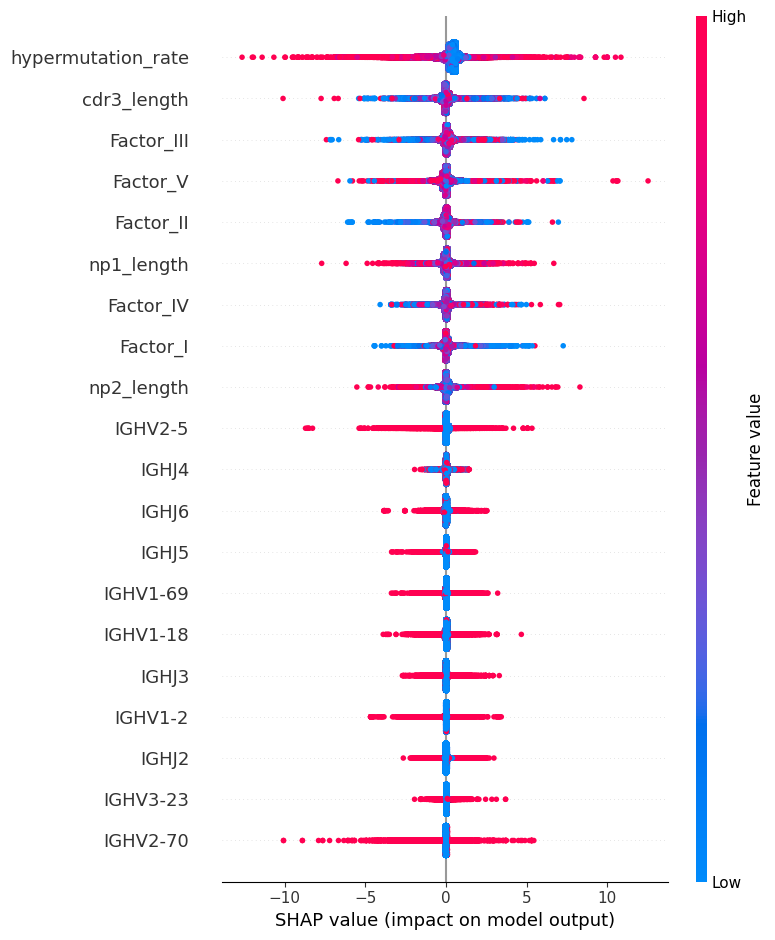

: 

In [ ]:
model.eval()
model.cpu()

# Background and test data (NumPy)
#background = X_test_scaled.iloc[:100].to_numpy().astype(np.float32)
background = X_test_tensor[:100]
test_samples = X_test_tensor[:150000]

# Use SHAP's DeepExplainer
explainer = shap.DeepExplainer(model, background)

# Compute SHAP values
shap_values = explainer.shap_values(test_samples)

# shap_values will be a list; extract the first item for binary classification
shap_values = shap_values.squeeze()  # shape: (N, num_features)

# Plot the summary with correct feature names
shap.summary_plot(shap_values, test_samples, feature_names=X_test_scaled.columns)

In [ ]:

test_samples_np = test_samples.numpy()
test_samples_np.shape, shap_values.shape


shap.force_plot(explainer.expected_value[0], shap_values, test_samples_np, feature_names=X_test_scaled.columns)

/home/s2106664/.conda/envs/mscproject/lib/python3.10/site-packages/shap/plots/_force.py:211: UserWarning: shap.plots.force is slow for many thousands of rows, try subsampling your data.
  warnings.warn("shap.plots.force is slow for many thousands of rows, try subsampling your data.")
